# Gaussian process regression

Comparison to baselines

### Table of contents

1. [**Data**](#data)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)

This notebook contains code demonstrating how to do regression.
- Linear regression
- Fitting a spike train with a renewal process GP
- Computing the renewal process likelihood landscape
- Performing GPLVM on a biological data for dimensionality reduction

In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append("..")


import neuroprob as nprb
from neuroprob import utils


dev = nprb.inference.get_device()  # PyTorch device, gpu 0 by default if available

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.13.0+cu117
Using device: cuda:0


### Spike train GP
Here we fit several trials of an inhomogenous Poisson process GP to a spike train. To improve optimization, we use the natural gradient.

In [14]:
tbin = 0.001
steps = 1000
max_time = tbin*steps
trials = 10
neurons = 2

rate = np.empty((trials, neurons, steps))
rate[:, 0, :] = (20.0*np.sin(2*np.pi*np.arange(steps)/1000) + 20.0)[None, :].repeat(trials, axis=0)
rate[:, 1, :] = (20.0*np.cos(2*np.pi*np.arange(steps)/1000) + 20.0)[None, :].repeat(trials, axis=0)


spikes = np.random.binomial(1, rate * tbin)  # generate spike trains

times = np.arange(steps)*tbin # time points to evaluate
covariates = times[None, :, None].repeat(trials, axis=0) # input regressors of shape (trials, time, dimensions)


t_spike = []
for t in range(trials):
    t_spike.append(np.where(spikes[t, ] > 0)[0])

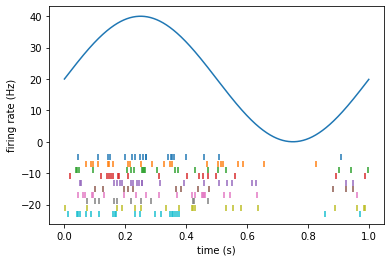

In [21]:
visualize_neuron = 0

plt.plot(times, rate[0, visualize_neuron])
for n in range(trials):
    plt.scatter(t_spike[n]*tbin, (-5.0-2*n)*np.ones_like(t_spike[n]), marker='|')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.show()

In [25]:
l = 0.1*np.ones((1, neurons)) # shape (input dimensions, output dimensions)
v = 1.*np.ones(neurons) # shape (output dimensions,)
kernels_tuples = [('variance', v), 
                  ('RBF', 'euclid', l)]
VI_tuples = [(None, None, None, 1)] # prior, var. dist., topology, dimensions

num_induc = 8
indps = np.linspace(0, max_time, num_induc)
inducing_points = indps[None, :, None].repeat(neurons, axis=0) # shape (output dims, time, input dims)

rate_model = nprb.mappings.SVGP(
    neurons, # number of neurons
    inducing_points, # initial inducing points
    kernels_tuples, # kernels
    VI_tuples, # priors and variational distributions
    mean=np.zeros((neurons)), # initial GP mean
    inv_link='exp', # inverse link function
    kern_f='softplus' # kernel inverse link
)

TypeError: __init__() got an unexpected keyword argument 'inv_link'

In [92]:
# likelihood model
likelihood = neuroprob.likelihoods.Poisson(
    neurons, # number of neurons or output dimensions
    'exp' # inverse link function
)

likelihood.set_params(tbin, jitter=1e-5)

In [93]:
# put together in GLM framework
glm = neuroprob.inference.VI_optimized([rate_model], likelihood)
glm.preprocess(
    [covariates], # list of input regressors of GP
    covariates.shape[1], # number of timesteps in total
    spikes, # spike trains
    batch_size=1000 # batch size (over timesteps)
)
    
glm.to(dev) # move to GPU if available

nll_optimized(
  (likelihood): Poisson()
  (rate_model): ModuleList(
    (0): Gaussian_process(
      (kernel): Product(
        (kern0): Constant()
        (kern1): RBF()
      )
    )
  )
)

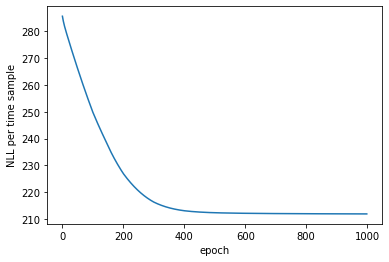

In [94]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (
    optim.Adam, # optimizer
    100, # scheduler time steps for iteration
    sch # scheduler effect
)
opt_lr_dict = {'default': 1e-2}

glm.set_optimizers(
    opt_tuple, 
    opt_lr_dict, 
    nat_grad=('rate_model.0.u_loc', 'rate_model.0.u_scale_tril'), 
    nat_lr=1e-1
    #newton_grad=('rate_model.0.u_loc',), 
    #newton_lr=1e-1
)

annealing = lambda x: 1.0
losses = glm.fit(
    1000, # number of max iterations
    loss_margin=0e0, 
    stop_iters=100, 
    anneal_func=annealing, 
    cov_samples=trials, # need to put in trials as we are doing regression over trials 
    ll_samples=20, 
    ll_mode='MC',
    bound='ELBO'
)

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

In [6]:
# compare to true rate
steps= 100
show_neurons = [0, 1]
eval_times = np.linspace(0.0, max_time, steps)[None, :] # shape (dims, timesteps)

lower, mean, upper = rate_model.eval_rate(eval_times, show_neurons, 'posterior')

visualize_trial = 0
fig, axes = plt.subplots(1, 2)
for k, neuron in enumerate(show_neurons):
    
    ax = axes[k]
    ax.plot(np.linspace(0, max_time, rate.shape[-1]), rate[visualize_trial, neuron], 'r--', label='true rate')
    line, = ax.plot(eval_times[0], mean[k], label='GP posterior')
    ax.fill_between(
        eval_times[0], lower[k],
        upper[k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.legend()
    
fig.tight_layout()


    
# draw tuning curves
tuning = rate_model.eval_rate(eval_times, show_neurons, 'tuning', n_samp=10)
fig, axes = plt.subplots(1, 2)
for k_n in range(len(show_neurons)):
    
    ax = axes[k_n]
    
    for n in range(samp):
        ax.plot(eval_times[0], tuning[n, k_n, ...])

    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')

fig.tight_layout()


# show GP posterior properties
steps= 100
show_neurons = [0, 1]
fig, axes = plt.subplots(1, 2)
for k, neuron in enumerate(show_neurons):
    
    Xu = glm.rate_model[0].Xu.data.cpu().numpy()[neuron, :, 0]
    eval_times = [np.linspace(Xu.min()-1.0, Xu.max()+1.0, steps)]
    lower, mean, upper = rate_model.eval_rate(eval_times, neuron, 'posterior')
    
    ax = axes[k]
    ax.scatter(Xu, -5.0*np.ones_like(Xu), marker='+', label='inducing points')
    line, = ax.plot(eval_times[0], mean, label='GP posterior')
    ax.fill_between(
        eval_times[0], lower,
        upper, color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.legend()
    
fig.tight_layout()
plt.show()

NameError: name 'rate_model' is not defined

(4, 5)